# Analisis Exploratorio de Datos - Coursera

Importamos las librerias necesarias

In [3]:
#Importamos las librerias necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import ydata_profiling
from ydata_profiling import ProfileReport
import langdetect
from langdetect import detect
import googletrans
from googletrans import Translator

%matplotlib inline
%config IPCompleter.greedy=True

In [4]:
#Importamos los Datasets
coursera_courses = pd.read_csv(r"C:\Users\miche\OneDrive\Escritorio\Henry\Proyecto_DatAnalitycs\DataSets_originales\coursera_courses.csv", na_values=" ") #dataset importado ok
coursera_reviews = pd.read_csv(r"C:\Users\miche\OneDrive\Escritorio\Henry\Proyecto_DatAnalitycs\DataSets_originales\Coursera_reviews.csv", na_values=" ", parse_dates=["date_reviews"], infer_datetime_format=True) #dataset importado ok

Verificacion de que la importacion fue correcta

In [5]:
coursera_courses.head(2)

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada


In [6]:
coursera_reviews.head(2)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,2020-02-12,4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,2020-09-28,4,google-cbrs-cpi-training


Conteo de nulos

In [7]:
coursera_courses.isnull().sum()
#El datsaset coursera_courses no contiene nulos.

name           0
institution    0
course_url     0
course_id      0
dtype: int64

In [8]:
coursera_reviews.isnull().sum()
#El dataset coursera_reviews tiene valores nulos en la variable reviews. 

reviews         140
reviewers         0
date_reviews      0
rating            0
course_id         0
dtype: int64

Conteo de Duplicados

In [9]:
print(f'Valores Duplicados del dataset Coursera_courses: {coursera_courses.duplicated().sum()}')
print(f'Valores Duplicados del dataset Coursera_courses: {coursera_reviews.duplicated().sum()}')

Valores Duplicados del dataset Coursera_courses: 0
Valores Duplicados del dataset Coursera_courses: 934764


Borramo los registros duplicados y mantenemos el primero

In [10]:
coursera_reviews.drop_duplicates(keep="first", inplace=True)

Verificamos si los duplicados fueron removidos con exito

In [11]:
print(f'Valores Duplicados del dataset Coursera_courses: {coursera_reviews.duplicated().sum()}')

Valores Duplicados del dataset Coursera_courses: 0


In [12]:
#Reseteamos el Index del dataset
coursera_courses = coursera_courses.reset_index(drop=True)
coursera_reviews = coursera_reviews.reset_index(drop=True)

Agregamos las nuevas columnas:
* n_enrolled : int > la cual llevara 1 por cada review debido a que una review significa un inscrito.
* review_year : int
* review_month_name : category
* review_day_name : category
* n_reviews : int

In [13]:
#Creamos
coursera_reviews.insert(2, "n_enrolled", value=1)
coursera_reviews.insert(4, "review_year", value=0)
coursera_reviews.insert(5, "review_month_name", value=0)
coursera_reviews.insert(6, "review_day_name", value=0)
coursera_reviews.insert(7, "n_reviews", value=0)
coursera_reviews.insert(8, "mean_rating", value=0)


In [14]:
#Poblamos
coursera_reviews["review_year"] = coursera_reviews["date_reviews"].dt.year
coursera_reviews["review_month_name"] = coursera_reviews["date_reviews"].dt.month_name()
coursera_reviews["review_day_name"] = coursera_reviews["date_reviews"].dt.day_name()

Verificamos el dataset.

In [15]:
coursera_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519947 entries, 0 to 519946
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   reviews            519891 non-null  object        
 1   reviewers          519947 non-null  object        
 2   n_enrolled         519947 non-null  int64         
 3   date_reviews       519947 non-null  datetime64[ns]
 4   review_year        519947 non-null  int64         
 5   review_month_name  519947 non-null  object        
 6   review_day_name    519947 non-null  object        
 7   n_reviews          519947 non-null  int64         
 8   mean_rating        519947 non-null  int64         
 9   rating             519947 non-null  int64         
 10  course_id          519947 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 43.6+ MB


In [16]:
#Realizamos un conteo de las reviews por acumulado por cada course_id.
n_reviews = coursera_reviews.groupby('course_id')['course_id'].transform('count')
#Poblamos la nueva columna
coursera_reviews["n_reviews"] = n_reviews
#Promediamos el Rating por cada uno de los course_id.
x_rating = coursera_reviews.groupby('course_id')['rating'].transform('mean')
#Poblamos la nueva columna
coursera_reviews["mean_rating"] = x_rating

Verificamos nuestro dataset con las nuevas columnas ya pobladas

In [17]:
coursera_reviews

,reviews,reviewers,n_enrolled,date_reviews,review_year,review_month_name,review_day_name,n_reviews,mean_rating,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,1,2020-02-12,2020,February,Wednesday,33,4.818182,4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,1,2020-09-28,2020,September,Monday,33,4.818182,4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,1,2020-04-08,2020,April,Wednesday,33,4.818182,4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,1,2020-02-24,2020,February,Monday,33,4.818182,4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,1,2020-06-18,2020,June,Thursday,33,4.818182,4,google-cbrs-cpi-training
...,...,...,...,...,...,...,...,...,...,...,...
519942,amazing,By FANISHA A A,1,2020-10-10,2020,October,Saturday,4813,4.628922,5,computer-networking
519943,great,By Ilona Y Z,1,2020-10-07,2020,October,Wednesday,4813,4.628922,5,computer-networking
519944,Nice,By Aung T K,1,2020-10-10,2020,October,Saturday,4813,4.628922,5,computer-networking
519945,Good,By Anthony N S,1,2020-10-08,2020,October,Thursday,4813,4.628922,5,computer-networking


In [18]:
#Unir los dos datasets de coursera para obtener uno solo.
coursera = pd.merge(coursera_courses, coursera_reviews, how="left", on="course_id")

#Llenamos los espacios vacios
coursera["rating"] = coursera["rating"].fillna(0)
coursera["review_year"] = coursera["review_year"].fillna(0)
coursera["reviews"] = coursera["reviews"].fillna(" ")
coursera["reviewers"] = coursera["reviewers"].fillna(" ")


Transformamos las nuevas columnas

In [19]:
coursera["review_year"] = coursera["review_year"].astype("category")
coursera["review_month_name"] = coursera["review_month_name"].astype("category")
coursera["review_day_name"] = coursera["review_day_name"].astype("category")

Pasamos de ingles a español

In [20]:
coursera.review_day_name = coursera.review_day_name.str.replace("Monday", "Lunes")
coursera.review_day_name = coursera.review_day_name.str.replace("Tuesday", "Martes")
coursera.review_day_name = coursera.review_day_name.str.replace("Wednesday", "Miercoles")
coursera.review_day_name = coursera.review_day_name.str.replace("Thursday", "Jueves")
coursera.review_day_name = coursera.review_day_name.str.replace("Friday", "Viernes")
coursera.review_day_name = coursera.review_day_name.str.replace("Saturday", "Sabado")
coursera.review_day_name = coursera.review_day_name.str.replace("Sunday", "Domingo")

#review_month_name
coursera.review_month_name = coursera.review_month_name.str.replace("January", "Enero")
coursera.review_month_name = coursera.review_month_name.str.replace("February", "Febrero")
coursera.review_month_name = coursera.review_month_name.str.replace("March", "Marzo")
coursera.review_month_name = coursera.review_month_name.str.replace("April", "Abril")
coursera.review_month_name = coursera.review_month_name.str.replace("May", "Mayo")
coursera.review_month_name = coursera.review_month_name.str.replace("June", "Junio")
coursera.review_month_name = coursera.review_month_name.str.replace("July", "Julio")
coursera.review_month_name = coursera.review_month_name.str.replace("August", "Agosto")
coursera.review_month_name = coursera.review_month_name.str.replace("September", "Septiembre")
coursera.review_month_name = coursera.review_month_name.str.replace("October", "Octubre")
coursera.review_month_name = coursera.review_month_name.str.replace("November", "Noviembre")
coursera.review_month_name = coursera.review_month_name.str.replace("December", "Diciembre")

Verificamos el dataset y la info para ver que todo este bien.

In [21]:
coursera.head(2)

,name,institution,course_url,course_id,reviews,reviewers,n_enrolled,date_reviews,review_year,review_month_name,review_day_name,n_reviews,mean_rating,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,1.0,2017-03-18,2017.0,Marzo,Sabado,12677.0,4.739923,1.0
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,1.0,2015-11-09,2015.0,Noviembre,Lunes,12677.0,4.739923,1.0


In [22]:
coursera.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519966 entries, 0 to 519965
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   name               519966 non-null  object        
 1   institution        519966 non-null  object        
 2   course_url         519966 non-null  object        
 3   course_id          519966 non-null  object        
 4   reviews            519966 non-null  object        
 5   reviewers          519966 non-null  object        
 6   n_enrolled         519947 non-null  float64       
 7   date_reviews       519947 non-null  datetime64[ns]
 8   review_year        519966 non-null  category      
 9   review_month_name  519947 non-null  object        
 10  review_day_name    519947 non-null  object        
 11  n_reviews          519947 non-null  float64       
 12  mean_rating        519947 non-null  float64       
 13  rating             519966 non-null  float64 

Borramos index incorrectos

In [23]:
coursera.drop([203672, 245302, 268856, 314529, 365188, 385918, 400829, 430015,
            447693, 448274, 477850, 477851, 478352, 488775, 489580, 500974,
            504353, 519964, 519965],axis=0, inplace=True)

Creacion de Funciones

In [24]:
def word_cloud(variable:str, numero_palabras=200):
    
    
    """
    Funcion creada para poder ser utilizada las variables Cualitativas que puedan contener textos largos.
    Args:
        variable (str): Este argumento recibe el nombre de la columna que queremos consultar
        numero_palabras (int, optional): Este argumento recibe el maximo numero de palabras que queremos ver en nuestro wordcloud. Valor por defecto 100.
    """
    
    
    listaPalabras = []
    for elemento in coursera[variable]:
        listaPalabras.append(elemento)

    #Hacemos la union de cada palabra, para convertirla a un str
    listaPalabras = " ".join(listaPalabras)
    listaPalabras = listaPalabras.replace("'", "")

    #creamos la variable que contiene stopwords de ingles y español
    stop_words = set(stopwords.words(["spanish", "english"]))

    #Generamos el wordcloud
    wordcloud = WordCloud(stopwords=stop_words, background_color="white", relative_scaling=0, max_words=numero_palabras).generate(listaPalabras)

    # Procesar el texto para obtener las frecuencias de las palabras
    frecuencias = wordcloud.process_text(listaPalabras)

    #Cambiamos el orden de las frecuencias
    frecuencias = dict(sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)[:numero_palabras])
    
    # Generar la nube de palabras a partir de las frecuencias
    wordcloud.generate_from_frequencies(frecuencias)
    
    #Creamos la figura:
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    print(f'Las {numero_palabras} palabras mas frecuentes dentro de la variable {variable} son : {frecuencias}')
    

# Analisis Univariante

name - wordcloud

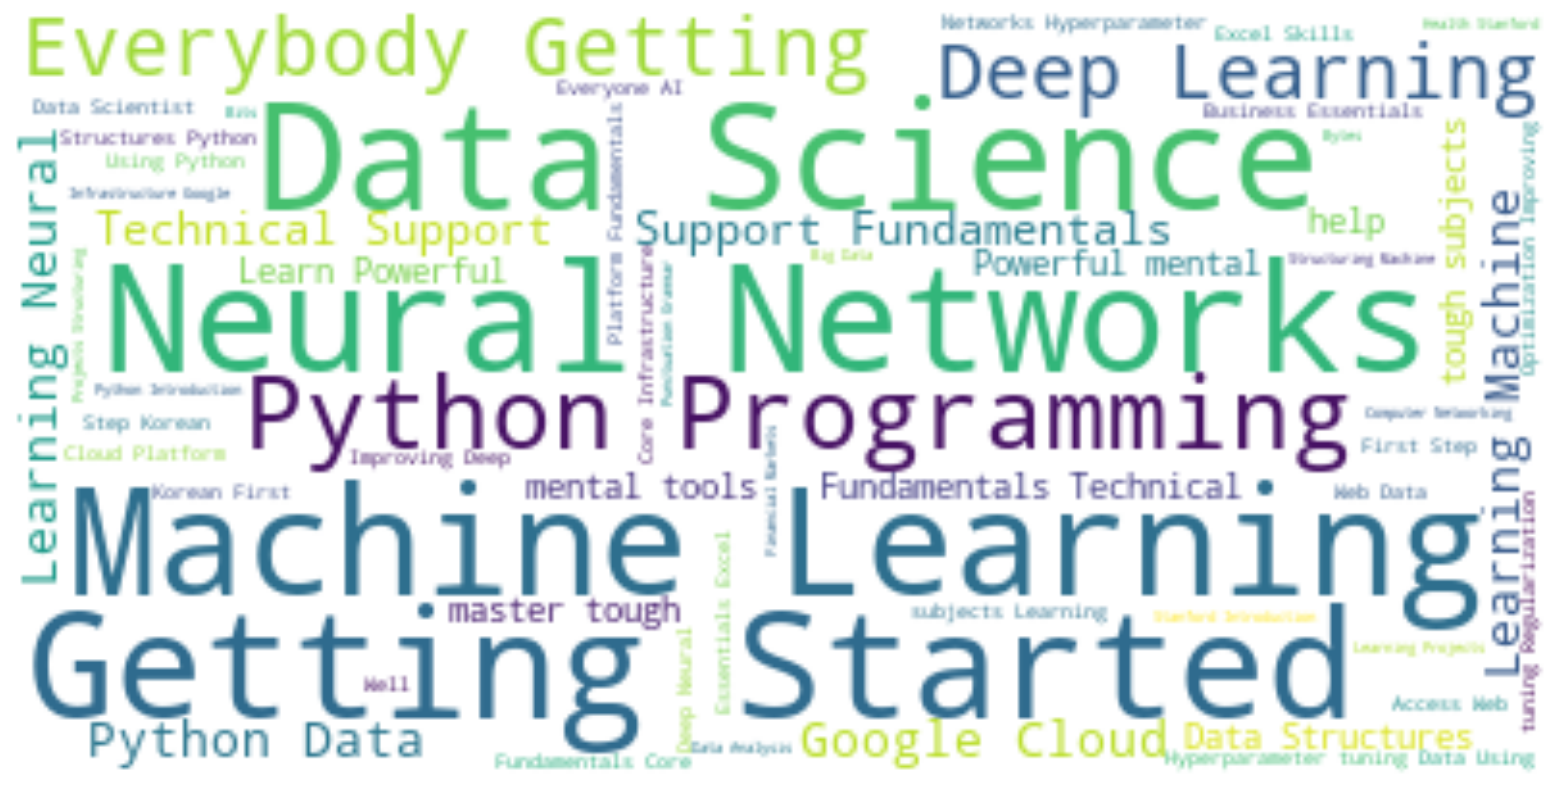

Las 200 palabras mas frecuentes dentro de la variable name son : {'Machine Learning': 34504, 'Data Science': 28330, 'Neural Networks': 20557, 'Getting Started': 18831, 'Python Programming': 16386, 'Everybody Getting': 15226, 'Deep Learning': 14888, 'Python Data': 14282, 'Google Cloud': 12742, 'Learning Machine': 12676, 'Learning Neural': 12291, 'Technical Support': 12055, 'Support Fundamentals': 12055, 'Fundamentals Technical': 12054, 'Data Structures': 11902, 'help': 11871, 'Learn Powerful': 11871, 'Powerful mental': 11871, 'mental tools': 11871, 'master tough': 11871, 'tough subjects': 11871, 'subjects Learning': 11870, 'Structures Python': 11421, 'Excel Skills': 11380, 'Cloud Platform': 8617, 'Well': 8199, 'Everyone AI': 7385, 'Business Essentials': 7377, 'Essentials Excel': 7376, 'Using Python': 6990, 'Access Web': 6485, 'Web Data': 6485, 'Data Using': 6484, 'Improving Deep': 6165, 'Deep Neural': 6165, 'Networks Hyperparameter': 6165, 'Hyperparameter tuning': 6165, 'tuning Regulari

In [25]:
word_cloud("name")

Insight:
* Como en los demas datasets estudiados podemos observar que sigue predominante cursos con indole de Programacion.
* Para este el top 3 representa diferentes ramas que utilizan Python como lenguaje de programacion.

institution - bar

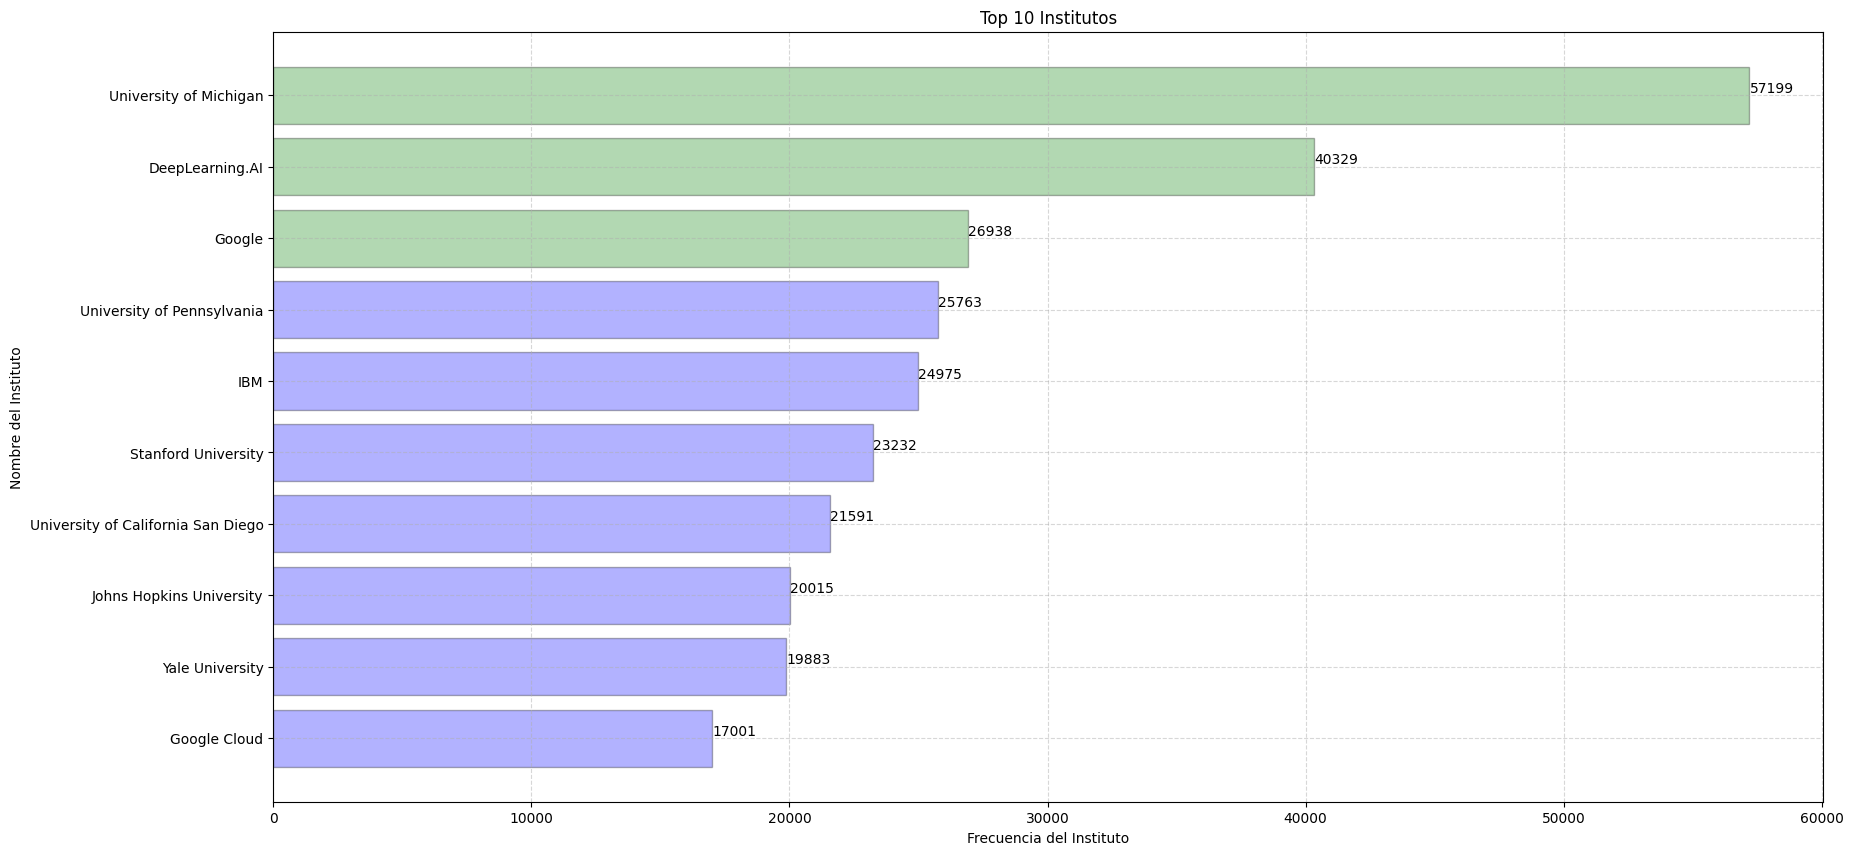

In [26]:
#Contamos:
conteo_instituto = coursera.institution.value_counts()[:10].sort_values(ascending=False).sort_values()

#Creamos la figura y ejes:
f, ax = plt.subplots(figsize=(20,10))
ax.barh(conteo_instituto.index, conteo_instituto.values, edgecolor="black",color=["blue", "blue","blue","blue", "blue","blue","blue","green","green","green"], alpha=0.3)
ax.set_ylabel("Nombre del Instituto")
ax.set_xlabel("Frecuencia del Instituto")
ax.set_title("Top 10 Institutos")
ax.grid(visible=True, ls="--", alpha=0.5)

#Iteramos para poner etiquetas:
for ind, val in enumerate(conteo_instituto):
    plt.text(val, ind, int(val), ha="left", va="bottom")
plt.show();

Insight:
* Es muy importante resaltar que las palabras con mayor frecuencia en los "name" hacen referencia a Ciencia de la Computacion, Web Development y en este grafico podemos ver que esta en lo correcto que el segundo instituto sea DeepLearning el cual dicta cursos Machine Learning, IA, Python.

reviews - wordcloud

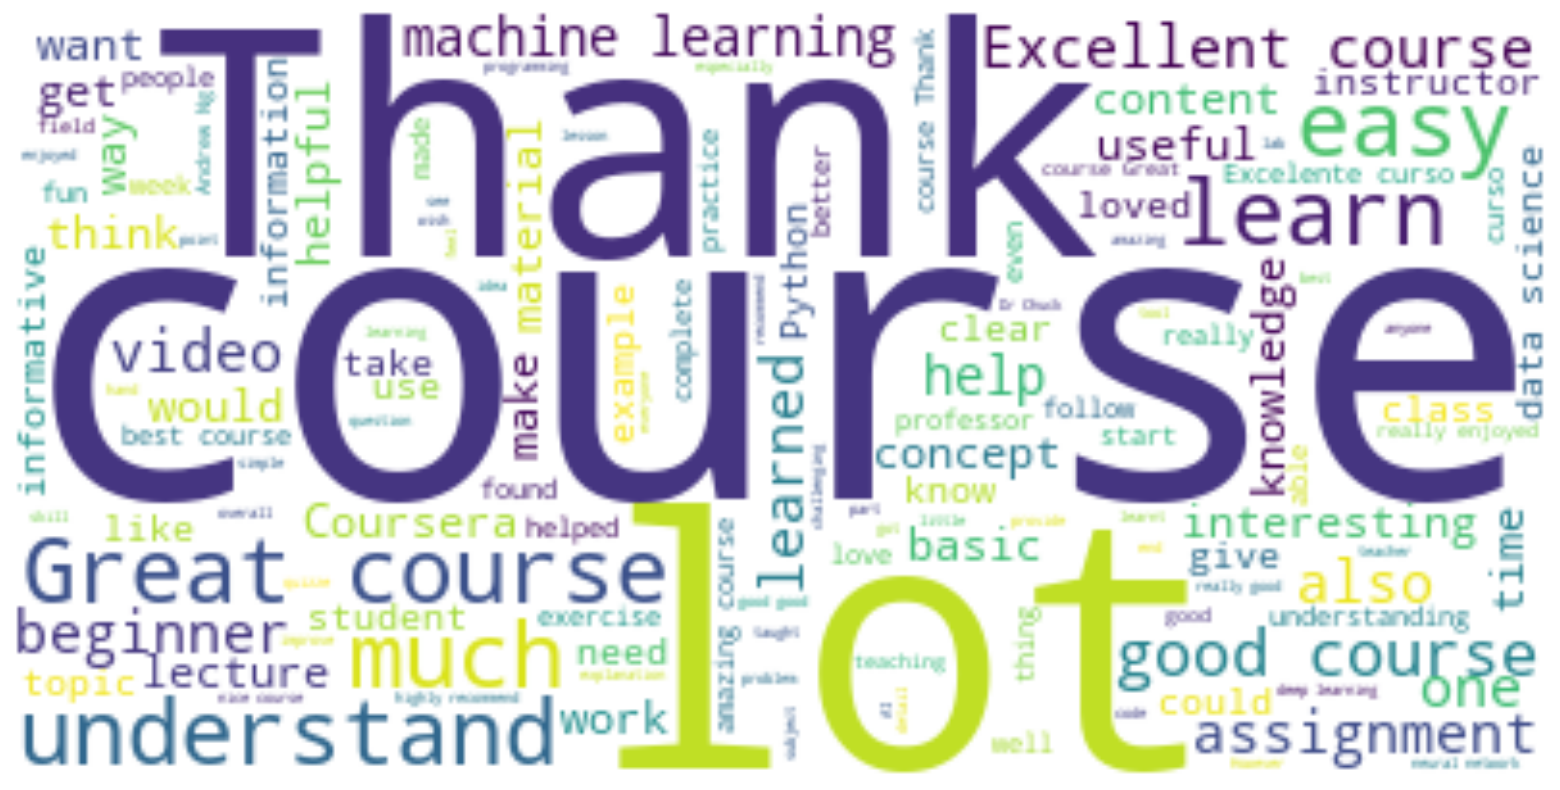

Las 200 palabras mas frecuentes dentro de la variable reviews son : {'course': 118008, 'lot': 41022, 'Thank': 33668, 'Great course': 31240, 'learn': 29716, 'understand': 24950, 'much': 23075, 'easy': 21317, 'good course': 19658, 'Excellent course': 17736, 'learned': 17541, 'video': 16557, 'one': 15486, 'also': 15263, 'assignment': 14634, 'beginner': 14211, 'machine learning': 13996, 'help': 13800, 'interesting': 13790, 'get': 13703, 'way': 13560, 'basic': 13530, 'useful': 13426, 'knowledge': 13327, 'concept': 13087, 'want': 12920, 'time': 12903, 'would': 12802, 'content': 12528, 'helpful': 12510, 'make': 11906, 'Coursera': 11900, 'think': 11847, 'lecture': 11621, 'material': 11620, 'work': 11588, 'instructor': 11484, 'Python': 10991, 'like': 10637, 'informative': 10345, 'know': 10137, 'take': 10032, 'clear': 9819, 'need': 9808, 'student': 9748, 'topic': 9543, 'use': 9477, 'could': 9040, 'data science': 9008, 'information': 8923, 'loved': 8888, 'give': 8798, 'class': 8717, 'example': 86

In [27]:
word_cloud("reviews")

Insight:
* Las palabras mas frecuentes fueron usadas para dar reconocimiento o agradecimiento al curso que el usuario realizo.

reviewers - wordcloud

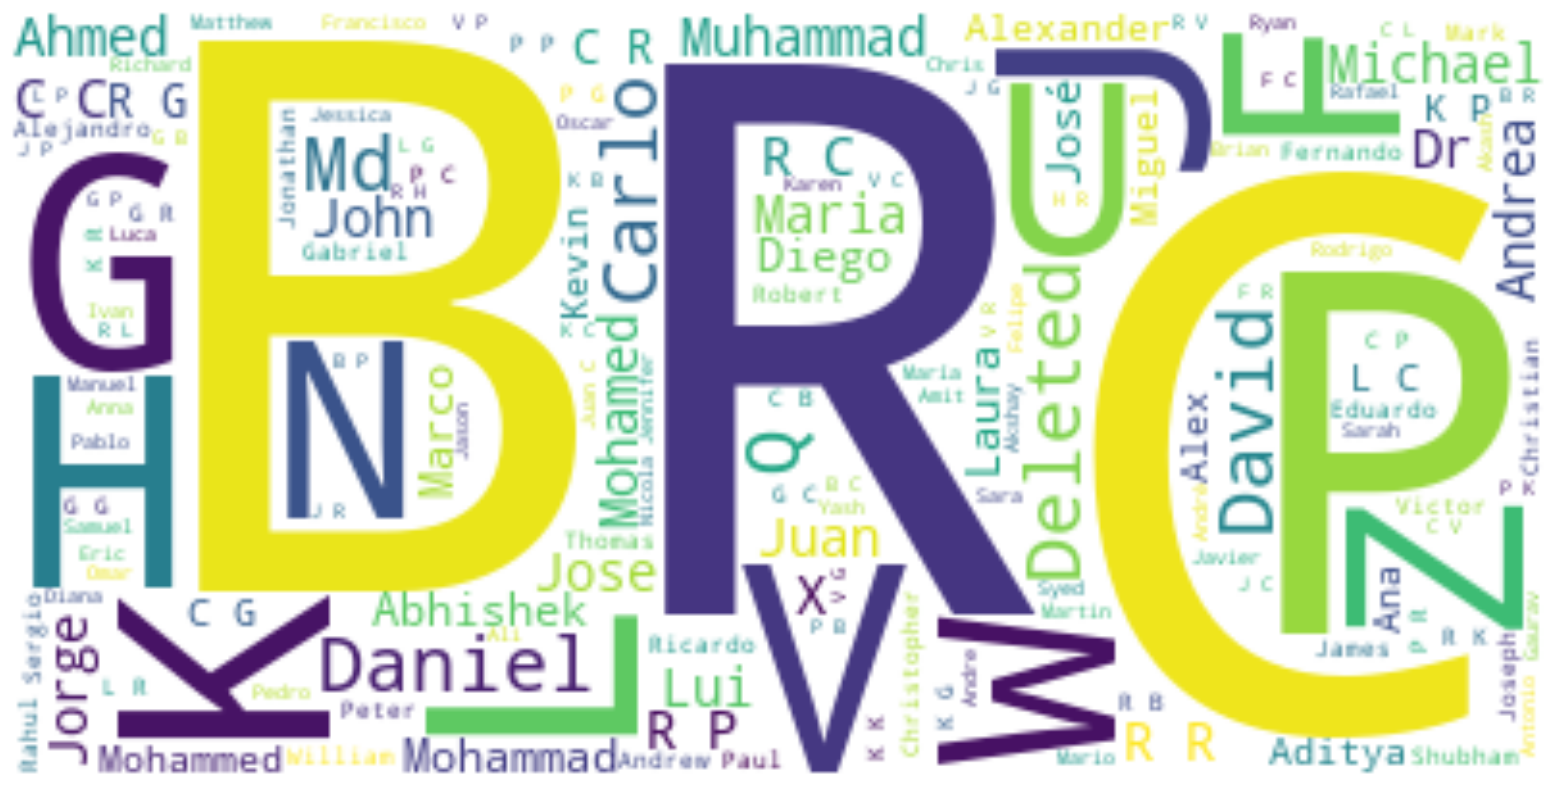

Las 200 palabras mas frecuentes dentro de la variable reviewers son : {'B': 26338, 'C': 24462, 'R': 24321, 'P': 23916, 'G': 22348, 'K': 21879, 'H': 15824, 'L': 15309, 'J': 13347, 'V': 12710, 'N': 12510, 'F': 8324, 'W': 7436, 'Z': 5494, 'U': 2883, 'Daniel': 2337, 'David': 2179, 'Q': 2107, 'Carlo': 1993, 'Md': 1955, 'Deleted': 1930, 'Muhammad': 1903, 'Dr': 1709, 'Lui': 1625, 'Michael': 1565, 'John': 1497, 'Maria': 1410, 'Juan': 1384, 'Jose': 1376, 'Mohamed': 1353, 'C C': 1263, 'Ahmed': 1254, 'Jorge': 1136, 'R R': 1054, 'X': 1039, 'R C': 1038, 'Andrea': 1034, 'R P': 1027, 'Mohammad': 1020, 'José': 1004, 'Laura': 988, 'Abhishek': 981, 'R G': 951, 'Diego': 943, 'C R': 940, 'Marco': 921, 'Aditya': 898, 'L C': 898, 'Ana': 894, 'Mohammed': 890, 'Kevin': 876, 'C G': 864, 'Miguel': 851, 'Alex': 842, 'Alexander': 822, 'K P': 817, 'Alejandro': 813, 'G C': 810, 'Rahul': 803, 'R B': 799, 'Ricardo': 797, 'G G': 796, 'Christopher': 794, 'G R': 794, 'K R': 780, 'Fernando': 777, 'Shubham': 774, 'C P': 7

In [28]:
word_cloud("reviewers")

Insight:
* No podemos obtener informacion relevante de los nombres de los usuarios

n_enrolled - barh

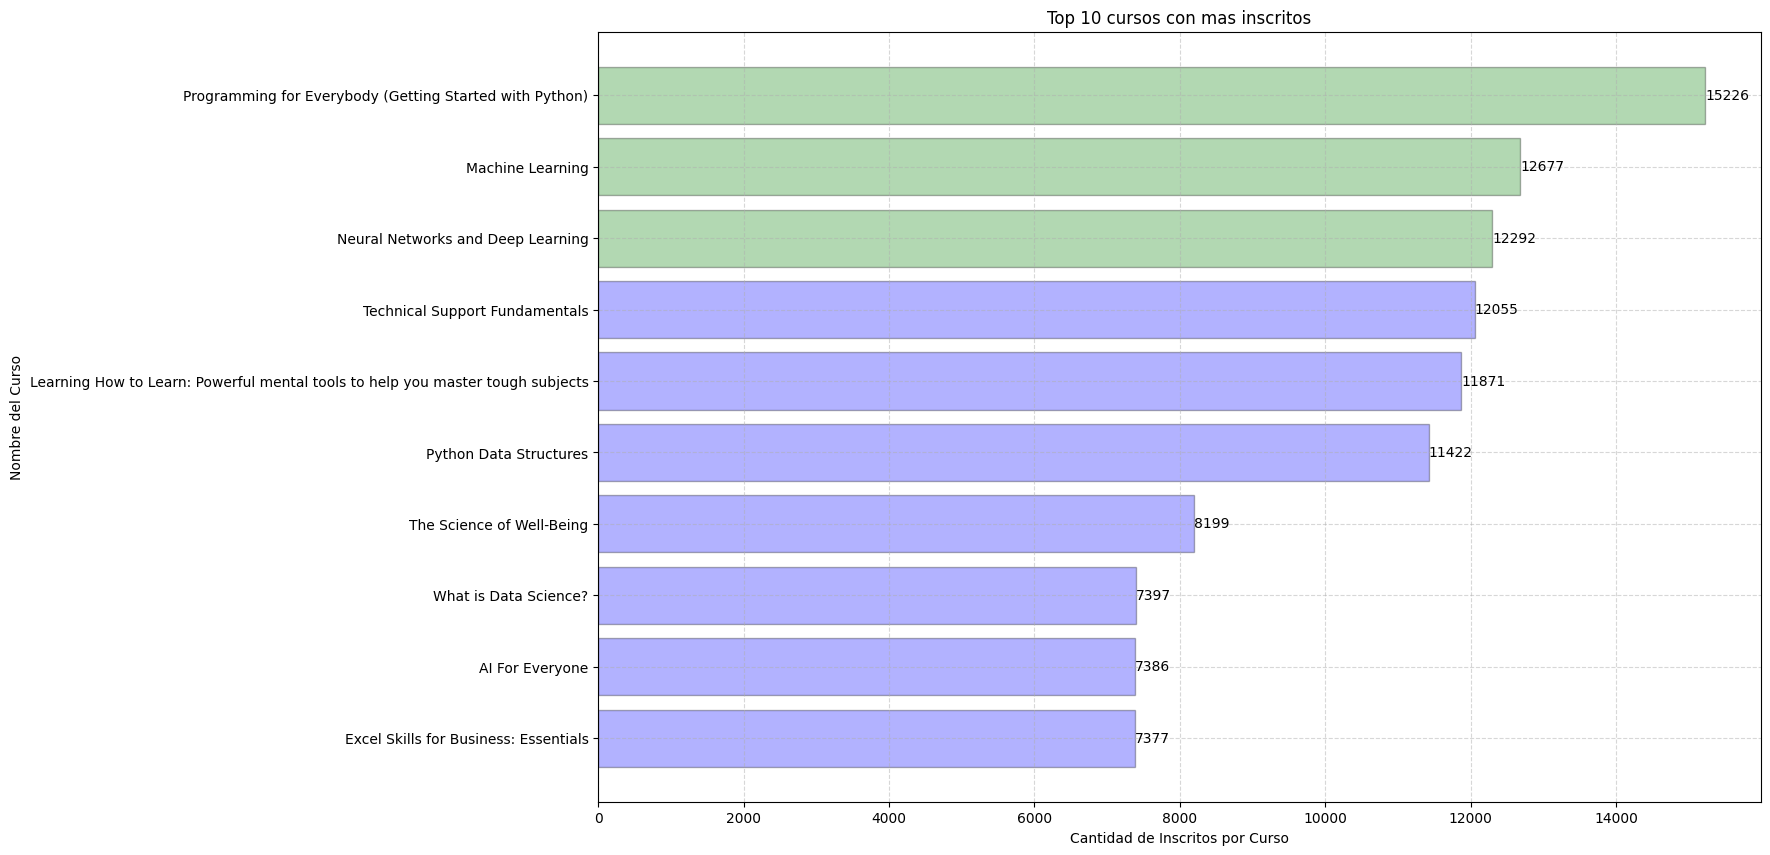

In [29]:
#Contamos:
conteo_enrolled = coursera.groupby("name")["n_enrolled"].sum().sort_values(ascending=False)[0:10].sort_values()

#Creamos la figura y ejes:
f, ax = plt.subplots(figsize=(15,10))
ax.barh(conteo_enrolled.index, conteo_enrolled.values,  color=["blue", "blue", "blue", "blue", "blue","blue", "blue", "green", "green","green"], edgecolor="black",alpha=0.3)
ax.set_xlabel("Cantidad de Inscritos por Curso")
ax.set_ylabel("Nombre del Curso")
ax.set_title("Top 10 cursos con mas inscritos")
ax.grid(visible=True, ls="--", alpha=0.5)

#Iteramos para poner etiquetas:
for i in range(len(conteo_enrolled.values)):
    ax.text(conteo_enrolled.values[i], conteo_enrolled.index[i], int(conteo_enrolled.values[i]), ha='left', va='center')
plt.show();

Insight:

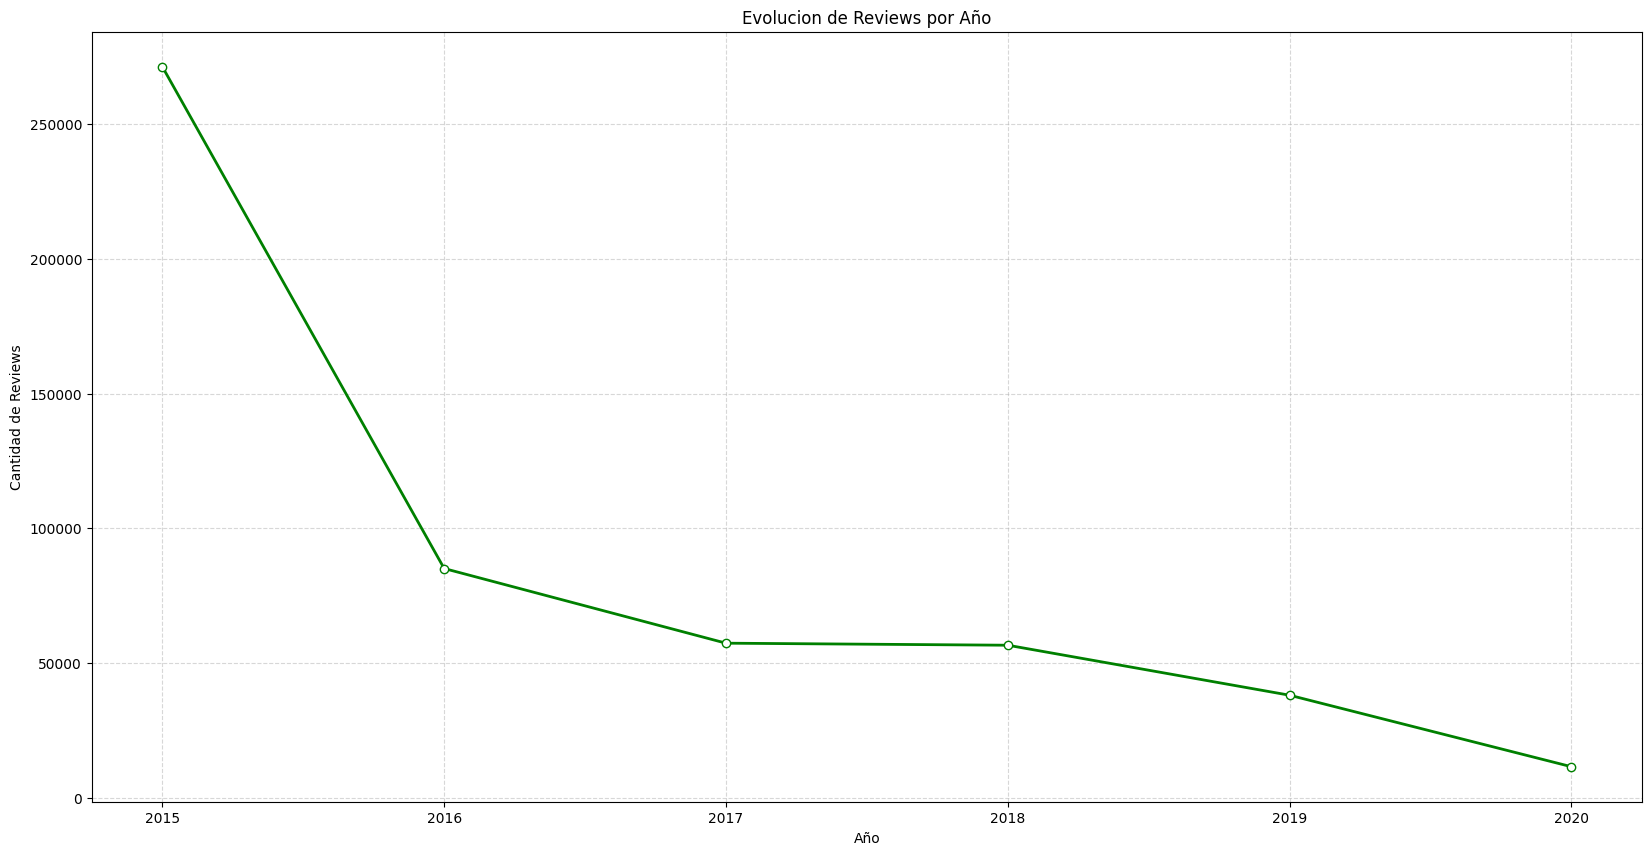

In [30]:
#Contamos:
conteo_pyear = coursera.review_year.value_counts().sort_values(ascending=False)[0:6]
anios = [2015,2016,2017,2018,2019,2020]
#Creamos la figura y ejes:
f, ax = plt.subplots(figsize=(20,10))
ax.plot(anios, conteo_pyear.values, color= "green",lw=2 ,marker="o", markerfacecolor="white")
ax.set_ylabel("Cantidad de Reviews")
ax.set_xlabel("Año")
ax.set_title("Evolucion de Reviews por Año")
ax.grid(visible=True, ls="--", alpha=0.5)

plt.show();

Insight:
* Para el año 2015 se tuvieron casi 270.000 reseñas sin embargo para los siguientes va en descenso viendo que en el 2016 baja a un poco menos de 100.000 lo que representa una disminucion de casi un 70% del total de reseñas del 2015.


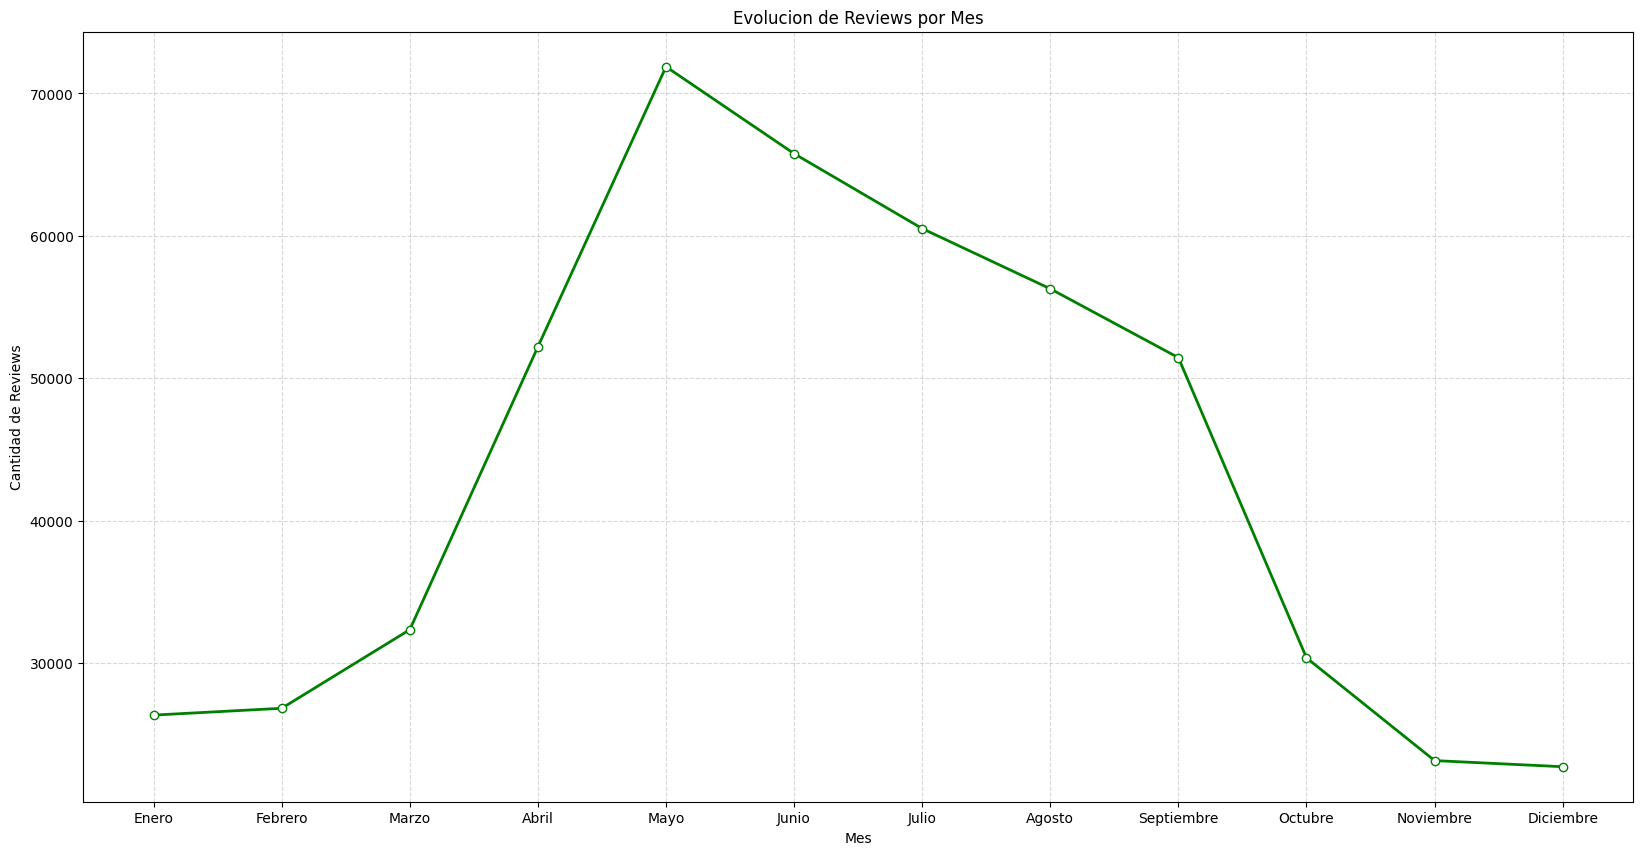

In [31]:
#Contamos:
conteo_pmonth = coursera.review_month_name.value_counts().sort_values(ascending=False)
#Reindex
meses_esp = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

#nueva variable con el index necesario
conteo_pmonth = conteo_pmonth.reindex(meses_esp)
#Creamos la figura y ejes:
f, ax = plt.subplots(figsize=(20,10))
ax.plot(conteo_pmonth.index, conteo_pmonth.values, color= "green",lw=2 ,marker="o", markerfacecolor="white")
ax.set_ylabel("Cantidad de Reviews")
ax.set_xlabel("Mes")
ax.set_title("Evolucion de Reviews por Mes")
ax.grid(visible=True, ls="--", alpha=0.5)


plt.show();

Insight:
* Desde enero a mayo hubo un incremento constante con respecto al mes anterior en las reseñas que dejan los usuarios sobre el curso que realiza.
* Declive constante desde el mes de mayo hasta diciembre, donde este es el punto mas bajo de todo el año.

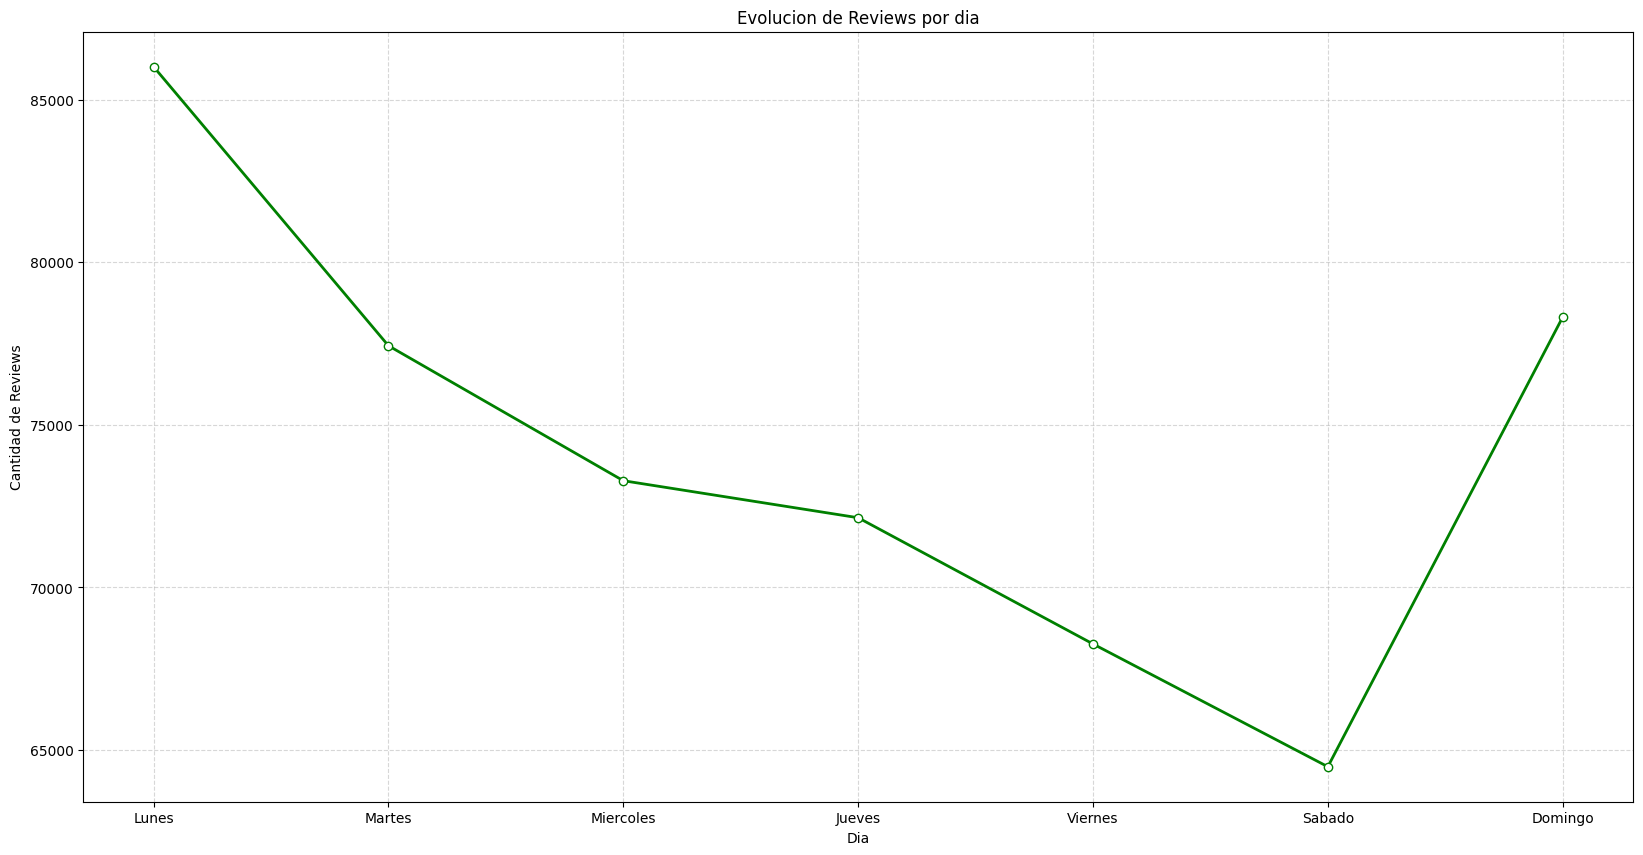

In [32]:
#Contamos:
conteo_pday = coursera.review_day_name.value_counts().sort_values(ascending=False)

#reindex
dias_esp = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

#nueva variable con el index necesario
conteo_pday = conteo_pday.reindex(dias_esp)

#Creamos la figura y ejes:
f, ax = plt.subplots(figsize=(20,10))
ax.plot(conteo_pday.index, conteo_pday.values, color= "green",lw=2 ,marker="o", markerfacecolor="white")
ax.set_ylabel("Cantidad de Reviews")
ax.set_xlabel("Dia")
ax.set_title("Evolucion de Reviews por dia")
ax.grid(visible=True, ls="--", alpha=0.5)


plt.show();

Insight:
* Podemos observar que el punto mas bajo de las reviews son los dias sabados
* Desde el dia lunes hasta el sabado ocurre un declive en los usuarios que dejan alguna reseña sobre el curso que realizan.

# Analisis Multivariable

Para el analisis multivariable se realizan tablas pivot para entender mejor la data y extraer la mayor informacion posible.

In [33]:
multiva_1 = pd.pivot_table(coursera, index=["review_year"], values=["n_enrolled", "rating"],  aggfunc=["sum", "mean"], fill_value={"sum":0, "mean":0})
multiva_1 = multiva_1.sort_values([('mean', 'rating')], ascending=[False])
multiva_1

sum                  mean          
            n_enrolled     rating n_enrolled    rating
review_year                                           
2020.0        271237.0  1278533.0        1.0  4.713712
2017.0         56625.0   265480.0        1.0  4.688389
2019.0         85082.0   396806.0        1.0  4.663807
2018.0         57380.0   267597.0        1.0  4.663594
2015.0         11550.0    53751.0        1.0  4.653766
2016.0         38073.0   175991.0        1.0  4.622462
0.0                0.0        0.0        NaN       NaN

Insight:
* Podemos apreciar que el rating por año se situo por encima del 4.5/5
* El año que tuvo la mayor cantidad de alumnos fue el 2020
* Entre el año 2018 y 2019 el incremento de uno año sobre el otro fue del 0,0000456%.

In [34]:
multiva_2 = pd.pivot_table(coursera, index=["institution"], values=["n_enrolled", "rating"],  aggfunc=["sum", "mean"], fill_value=0)
multiva_2 = multiva_2.sort_values([('mean', 'rating')], ascending=[False])
multiva_2

sum              mean          
                                  n_enrolled rating n_enrolled    rating
institution                                                             
GitLab                                     5     25          1  5.000000
Universidade Estadual de Campinas        469   2308          1  4.921109
University of Rochester                   76    374          1  4.921053
Arizona State University                2757  13519          1  4.903518
Universidad de los Andes                1442   7063          1  4.898058
...                                      ...    ...        ...       ...
Novosibirsk State University              77    314          1  4.077922
Yandex                                   126    439          1  3.484127
New York Institute of Finance            138    478          1  3.463768
Saint Petersburg State University         80    271          1  3.387500
University of New Mexico                   6      6          1  1.000000

[132 rows x 4 columns]

Insight:
* El instituto GitLab posee un rating de 5/5 sin embargo solamente tiene 5 alumnos y por ende es mucho mas facil obtener una calificacion considerada "perfecta"
* El segundo es una universidad la misma tiene un rating de 4.92/5 sobre un total de 469 alumnos por ende tomar una muestra de esta poblacion se puede considerar representativa de dicho rating.

In [35]:
multiva_3 = pd.pivot_table(coursera, index=["course_id"], values=["n_enrolled", "rating"],  aggfunc=["sum", "mean"], fill_value=0)
multiva_3 = multiva_3.sort_values([('sum', 'n_enrolled')], ascending=[False])
multiva_3

sum         \
                                                   n_enrolled rating   
course_id                                                              
python                                                  15226  69791   
machine-learning                                        12677  60088   
neural-networks-deep-learning                           12292  58648   
technical-support-fundamentals                          12055  57472   
learning-how-to-learn                                   11871  56995   
...                                                       ...    ...   
social-work-practice-advocating-social-justice-...          5     24   
remote-team-management                                      5     25   
the-business-of-product-management-one                      5     23   
entreprise-changement-climatique                            2     10   
building-modern-python-applications-on-aws                  1      5   

                                                         mean            
                                                   n_enrolled    rating  
course_id                                                                
python                                                      1  4.583673  
machine-learning                                            1  4.739923  
neural-networks-deep-learning                               1  4.771233  
technical-support-fundamentals                              1  4.767482  
learning-how-to-learn                                       1  4.801196  
...                                                       ...       ...  
social-work-practice-advocating-social-justice-...          1  4.800000  
remote-team-management                                      1  5.000000  
the-business-of-product-management-one                      1  4.600000  
entreprise-changement-climatique                            1  5.000000  
building-modern-python-applications-on-aws                  1  5.000000  

[604 rows x 4 columns]

Insight:
* Python tal como en los otros datasets explorados es una categoria o materia de estudio clave y por ello tiene la mayor cantidad de alumnos inscritos y un rating total de 4.58/5 lo que se podria considerar un excelente rating basandonos en los alumnos.
* En el segundo lugar con mas alumnos inscritos tenemos machine-learning que sin duda es una categoria de python.

In [36]:
coursera.insert(14, "MOOC", value="Coursera")

In [37]:
#Exportamos el dataset con las transformaciones realizadas.
coursera.to_csv("coursera_v2.csv", index=False)